# DYNAMITE and Bayes-LOSVD

BayesLOSVD is a tool for extraction of histogrammed LOSVDs from galaxy-spectra. This notebook was used for integrating BayesLOSVD output with DYNAMITE, and may be useful for anyone interested in these details. A mre streamlined version sould be made for the documentation.

## Data Preparation 

There are three steps in the data-preparation:

1. convert Bayes-LOSVD output to ECSV file
2. add the PSF to the ECSV file header
3. create auxillary files aperture.dat and bins.dat


I'll demonstrate these steps using Michela's CR galaxy IC0719. The data for this galaxy has not been included.

**Note for public release** - swap to the example `NGC0000-SP_results.hdf5` given in Bayes-LOSVD output.

#### Convert Bayes-LOSVD output to ECSV file

First let's make an "empty" BayesLOSVD object,

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dynamite as dyn

In [2]:
BayesLOSVD = dyn.kinematics.BayesLOSVD(weight=1.,
                                       hist_width=1,
                                       hist_center=0,
                                       hist_bins=0,
                                       type='BayesLOSVD')

We've had to provide some default values for certain keyword parameters, but they won't be used. All we want it to able to use the method `write_losvds_to_ecsv_format` to convert the results to the required ECSV format,

In [3]:
filename = 'IC0719_input/IC0719_CaT_1-SP_results.hdf5'
BayesLOSVD.write_losvds_to_ecsv_format(filename,
                                       outfile='IC0719_input/bayes_losvd_kins.ecsv')

This creates a file `bayes_losvd_kins.ecsv`.

#### add the PSF to the ECSV file header

Next add the PSF into the header of this file. This is specified as a Gaussian mixture with a list of sigmas and weights. Change these numbers to the correct PSF for your data,

In [4]:
BayesLOSVD.add_psf_to_datafile(sigma=[1.,2.],
                               weight=[0.6,0.4],
                               datafile='IC0719_input/bayes_losvd_kins.ecsv')

#### create auxillary files

We now create some auxillary files (`aperture.dat` and `bins.dat` files) which are used to bin orbit libraries. We first need to re-create the `BayesLOSVD` object, readin-in the ECSV table,

In [5]:
BayesLOSVD = dyn.kinematics.BayesLOSVD(datafile='IC0719_input/bayes_losvd_kins.ecsv',
                                       weight=1.,
                                       type='BayesLOSVD')

To create the auxillary files, we need to provide an angle (90 - position angle), and the galaxy center in pixel units. The center can either be a tuple $(x_0,y_0)$ or - as is done here - the string `'max_flux'` to use the pixel with maximum flux as center,

In [6]:
BayesLOSVD.write_aperture_and_bin_files(filename=filename,
                                        angle_deg=90.-53.,
                                        center='max_flux',
                                        aperture_filename='IC0719_input/aperture.dat',
                                        bin_filename='IC0719_input/bins.dat')

The two files are created in the directory `IC0719_input`.

All of these data preparation steps should be carried out before the main DYNAMITE run.

## Looking at the BayesLOSVD output

We can read create a new BayesLOSVD object, reading in all files we have just created,

In [7]:
BayesLOSVD = dyn.kinematics.BayesLOSVD(datafile='IC0719_input/bayes_losvd_kins.ecsv',
                                       aperturefile='IC0719_input/aperture.dat',
                                       binfile='IC0719_input/bins.dat',
                                       weight=1.,
                                       type='BayesLOSVD')

The data is stored in the data attribute,

In [8]:
BayesLOSVD.data

binID_BayesLOSVD,binID_dynamite,v,sigma,xbin,ybin,losvd [35],dlosvd [35]
int64,int64,float64,float64,float64,float64,float64,float64
0,1,25.139417714854346,150.30443226059708,-0.3333333333333357,-0.26666666666666927,0.0019416323497681881 .. 0.015259378139774543,0.005968342942902846 .. 0.01989741285762346
1,2,20.644287494418247,135.913029588071,-0.20000000000000284,-0.5499999999999972,0.004508561382520821 .. 0.004106415902383198,0.012054460545721686 .. 0.011563090410035497
2,3,12.405493855238923,155.3369584756288,0.10000000000000142,-0.3000000000000007,0.015386889344653404 .. 0.007710072525254317,0.016906022327590003 .. 0.01510201752165599
3,4,28.126960053791024,122.30574005867525,-0.30000000000000426,0.09999999999999787,0.0007614242053367949 .. 0.004090768456268483,0.002376875278290962 .. 0.01024960639403547
4,5,13.213971588565512,114.60562099791962,0.10000000000000142,0.09999999999999787,0.002205535931192645 .. 0.0018553695864067883,0.006721059434023896 .. 0.005951478462937457
5,6,39.948636367170344,171.18152737870957,-0.6799999999999997,-0.23999999999999844,0.005585052051007471 .. 0.0189432749850374,0.08714230636193271 .. 0.09528282444614967
6,7,42.913536165652346,158.24235963279546,-0.7199999999999989,0.23999999999999844,0.002535855487729973 .. 0.019946842755926494,0.0078523083547063 .. 0.018711449668939888
7,8,26.97309795915109,125.46661842022785,-0.30000000000000426,0.6000000000000014,0.0019774594743697392 .. 0.0043715624686085875,0.00635984346952707 .. 0.012516282251890123
8,9,29.120703908039957,141.27489949798658,0.20000000000000284,0.6000000000000014,0.001582232344009336 .. 0.013105487122553274,0.005274471848778314 .. 0.016294123929419715


**Note on bin IDs**: there are two binIDs in this table: BayesLOSVD and DYNMAITE. The differeces between these are:

1. BayesLOSVD bins are zero-indexed, while DYNAMITE (specifically fortran code) requires that  bins are 1-indexed,
2. BayesLOSVD bins may have some gaps (as some bins may be masked) while DYNATIMTE assumes the binIDs increase without gaps

You won't need to worry about this difference when running DYNAMITE, but be aware that of the difference for any later analysis.

The remaining columns are the LOSVD itself (`losvd`), the error on the LOSVD (`dlosvd`), its mean `v` and standard deviation `sigma`, and spatial bin co-ordinates (`xbin` and `ybin`). BayesLOSVD represents the LOSVD as a sequence of weights $L_i$ in velocity bins $v_i$. Details of the velocity array are stored as metadata to the data table,

In [9]:
print('Bayes-LOSVD table contains meta-data about: ', BayesLOSVD.data.meta.keys())
print('     velocity spacing of bins = ', BayesLOSVD.data.meta['dv'])
print('     number of spatial bins = ', BayesLOSVD.data.meta['nbins'])
print('     number of velocty bins = ', BayesLOSVD.data.meta['nvbins'])
print('     etc...')

Bayes-LOSVD table contains meta-data about:  odict_keys(['dv', 'nbins', 'nvbins', 'vcent', 'PSF'])
     velocity spacing of bins =  40.0
     number of spatial bins =  235
     number of velocty bins =  35
     etc...


BayesLOSVD samples the multi-dimensional posterior on the LOSVD weights $L_i$. The full multidimensional posterior is not saved by defaut, however. What is saved, and what is given in the table above, is the median and 68% Bayesian credible intervals for the weight in each velocity bin.

One important effect of this is on LOSVD normalisation. The posterior samples created by BayesLOSVD are normnalised to 1 i.e. 

$$
\sum_i L_i = 1
$$

(this is acheieved by using the `simplex` datatype in STAN). The default results file, however, gives median values per velocity bin. These are *not* normalised the same way. Let's call these median value,

$$
l_i = \mathrm{median}(L_{i})
$$

and look at a histogram of the sums of the $l_i$ in each spatial bin,

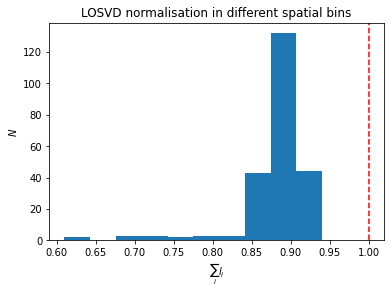

In [10]:
plt.hist(np.sum(BayesLOSVD.data['losvd'], 1))
plt.axvline(1., ls='--', color='r')
plt.gca().set_xlabel('$\sum_i l_{i}$')
plt.gca().set_ylabel('$N$')
_ = plt.gca().set_title('LOSVD normalisation in different spatial bins')

This peaks around 0.9 and, in some cases, is as low as 0.6, and it will be important to acccount for this. When calculating moments of the LOSVDs, for example, we will have to re-normalise. Let's define the re-normalised `losvd` as

$$
\hat{l}_{i} = \frac{l_{i}}{\sum_i l_{i}}
$$

This quantity $\hat{l}_{i}$ is what we will use to make point estimates of the the mean and standard deviation LOSVD which appear in the `v` and `sigma` columns of the data-table,

$$
v = \sum_i v_i * \hat{l}_{i}
$$

$$
\sigma = \left[ \sum_i (v_i-v)^2 * \hat{l}_{i} \right]^{\frac{1}{2}}
$$

Let's plot a few examples of LOSVDs and their Gaussian approximations using `v` and `sigma` in different spatial bins,

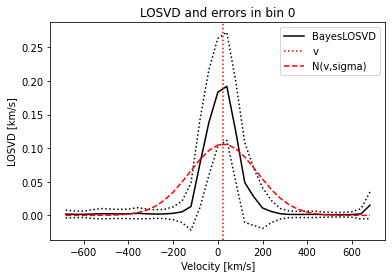

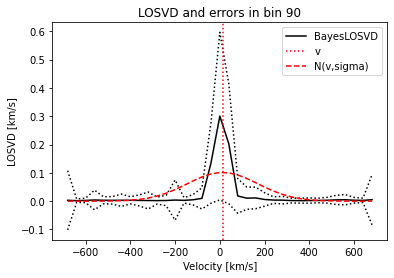

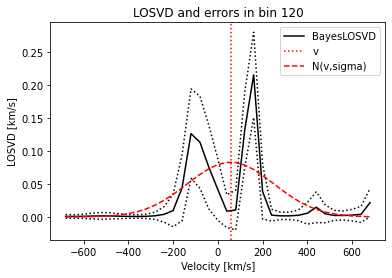

In [11]:
from scipy import stats

for bin_idx in [0, 90, 120]:
    mu = BayesLOSVD.data['losvd'][bin_idx,:]
    sig = BayesLOSVD.data['dlosvd'][bin_idx,:]
    vcent = BayesLOSVD.data.meta['vcent']
    plt.plot(vcent, mu, '-k', label='BayesLOSVD')
    plt.plot(vcent, mu+sig, ':k')
    plt.plot(vcent, mu-sig, ':k')
    v, sig = BayesLOSVD.data['v'][bin_idx], BayesLOSVD.data['sigma'][bin_idx]
    plt.gca().axvline(v, color='r', ls=':', label='v')
    nrm = stats.norm(v, sig)
    pdf = nrm.pdf(vcent)
    plt.gca().plot(vcent, pdf/np.sum(pdf), color='r', ls='--', label='N(v,sigma)')
    plt.gca().set_xlabel('Velocity [km/s]')
    plt.gca().set_ylabel('LOSVD [km/s]')
    _ = plt.gca().set_title(f'LOSVD and errors in bin {bin_idx}')
    plt.gca().legend()
    plt.show()

In the final example, the LOSVD is bimodal, and this is clearly not well matched at all by the Gaussian. But even in the previous two, unimodal, examples, the Gaussian approximations is not good. The Gaussians are much wider that the BayesLOSVD histograms. Why is this? Let's look at the two unimodal LOSVDs again, this time on a log-scale,

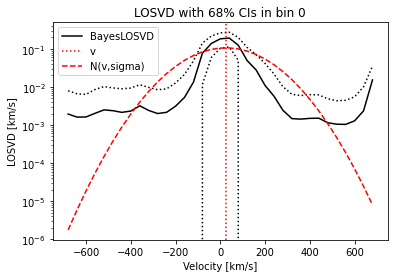

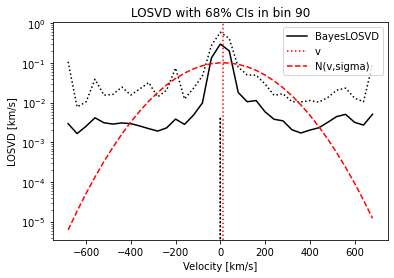

In [12]:
for bin_idx in [0, 90]:
    mu = BayesLOSVD.data['losvd'][bin_idx,:]
    sig = BayesLOSVD.data['dlosvd'][bin_idx,:]
    vcent = BayesLOSVD.data.meta['vcent']
    plt.plot(vcent, mu, '-k', label='BayesLOSVD')
    plt.plot(vcent, mu+sig, ':k')
    plt.plot(vcent, mu-sig, ':k')
    v, sig = BayesLOSVD.data['v'][bin_idx], BayesLOSVD.data['sigma'][bin_idx]
    plt.gca().axvline(v, color='r', ls=':', label='v')
    nrm = stats.norm(v, sig)
    pdf = nrm.pdf(vcent)
    plt.gca().plot(vcent, pdf/np.sum(pdf), color='r', ls='--', label='N(v,sigma)')
    plt.gca().set_xlabel('Velocity [km/s]')
    plt.gca().set_ylabel('LOSVD [km/s]')
    _ = plt.gca().set_title(f'LOSVD with 68% CIs in bin {bin_idx}')
    plt.gca().legend()
    plt.gca().set_yscale('log')
    plt.show()

we see that BayesLOSVD does not force the LOSVD to decay at large velocities. The fat tails give rise to large standard deviations. The `sigma` are unrepresentative of the width of the main body of the distribution. So, sigma maps for BayesLOSVD output would likely not be very useful. Quantile maps may be better.

## Running DYNAMITE

To run DYNAMITE with BayesLOSVD output, you need to specify `type: BayesLOSVD` in the kinemtics section of the configuration file. An example `IC0719_dynmaite_config.yaml` is provided in this directory. The relevant part for us is the following,

    system_components:
        ...
        stars:
            ...
            kinematics:
                MUSE_CaT:
                    weight: 1.0
                    type: BayesLOSVD
                    datafile: "bayes_losvd_kins.ecsv"
                    aperturefile: "aperture.dat"
                    binfile: "bins.dat"

The entry `MUSE_caT` is a descriptive name, which can be any name we wish to use for this kinematic dataset. In this case, the kinematics came from the calcium triplet using MUSE data, hence `MUSE_caT`. The `type` must be `BayesLOSVD`, and the filenames should be those produced in the data-preparaition step.

To read the configuration file,

In [13]:
fname = 'IC0719_dynamite_config.yaml'
c = dyn.config_reader.Configuration(fname, reset_logging=True)
# c.remove_all_existing_output(wipe_all=True)

[INFO] 09:57:16 - dynamite.config_reader.Configuration - Config file IC0719_dynamite_config.yaml read.
[INFO] 09:57:16 - dynamite.config_reader.Configuration - io_settings...
[INFO] 09:57:16 - dynamite.config_reader.Configuration - system_attributes...
[INFO] 09:57:16 - dynamite.config_reader.Configuration - model_components...
[INFO] 09:57:16 - dynamite.config_reader.Configuration - system_parameters...
[INFO] 09:57:16 - dynamite.config_reader.Configuration - orblib_settings...
[INFO] 09:57:16 - dynamite.config_reader.Configuration - weight_solver_settings...
[INFO] 09:57:16 - dynamite.config_reader.Configuration - parameter_space_settings...
[INFO] 09:57:16 - dynamite.config_reader.Configuration - legacy_settings...
[INFO] 09:57:16 - dynamite.config_reader.Configuration - multiprocessing_settings...
[INFO] 09:57:16 - dynamite.config_reader.Configuration - ... using 4 CPUs.
[INFO] 09:57:16 - dynamite.config_reader.Configuration - System assembled
[INFO] 09:57:16 - dynamite.config_read

When the configuration file is read into the configration object `c`. A `BayesLOSVD` object has been created, and we can extract this: it belongs to the `stars` component, and is the first (and in this case only) data set in the list of kinematic_data,

In [14]:
stars = c.system.get_component_from_name('stars')
BayesLOSVD = stars.kinematic_data[0]
print(type(BayesLOSVD))

<class 'kinematics.BayesLOSVD'>


If we want to plot maps using the spatial bins of this `BayesLOSVD` object, we can get its `map_plotter` function.

In [15]:
map_plotter = BayesLOSVD.get_map_plotter()
help(map_plotter)

Help on function map_plotter in module data:

map_plotter(bin_data, **kw_display_pixels)
    plot maps with the spatial binning of this dataset
    
    This is a wrapper around plotbin.display_pixel
    
    Parameters
    ----------
    bin_data : array (nbins,)
        the binned data to be plotted with entries ordered as the bins
        are ordered in the table self.data
    **kw_display_pixels : type
        keyword arguments passed directly to plotbin.display_pixel
    
    Returns
    -------
    None



We can use this function to plot the `v` column of the data, for example, as follows,

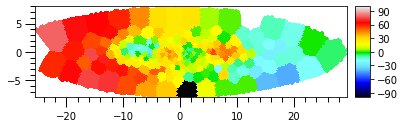

In [16]:
map_plotter(BayesLOSVD.data['v'], cmap='sauron', vmin=-100, vmax=100, colorbar=True)

### Calculating orbit libraries

Some quantites have been automatically set when the ocnfiguration has been read in. For example, the following settings define the histogram bins for storing LOSVDs of the orbit libraries,

In [17]:
print('Orbit LOSVD histogram width = ', BayesLOSVD.hist_width)
print('Orbit LOSVD histogram n bins = ', BayesLOSVD.hist_bins)
print('Orbit LOSVD histogram velocity spacing = ', BayesLOSVD.hist_width/BayesLOSVD.hist_bins)

Orbit LOSVD histogram width =  2800.0
Orbit LOSVD histogram n bins =  701
Orbit LOSVD histogram velocity spacing =  3.9942938659058487


These defaultss will scale with the input data provided - the range is double the data range, and the velocity spacing is about a tenth of the data spacing. To override the defaults, you can alternatively set the quantities in the configuration file, e.g.

    kinematics:
        MUSE_CaT
            hist_width: ...
            hist_bins: ...
            ...
                  
Let's calculate an orbit library,

In [18]:
parset0 = c.all_models.parspace.get_parset()
mod0 = dyn.model.Model(system=c.system,
                       settings=c.settings,
                       parspace=c.parspace,
                       parset=parset0)
mod0.setup_directories()
orblib0 = mod0.get_orblib()

Histograms of the LOSVDs of the orbit libraries are stored in the object `orblib0.losvd_histograms`. This is a list with one entry for each set of kinematics. As we only have one set of kinematics, we only will look at the 0'th entry,

In [19]:
print('type of orblib0.losvd_histograms[0] is ', type(orblib0.losvd_histograms[0]))
print('velocity array has shape ', orblib0.losvd_histograms[0].x.shape)
print('velocity histogram has shape ', orblib0.losvd_histograms[0].y.shape)

type of orblib0.losvd_histograms[0] is  <class 'kinematics.Histogram'>
velocity array has shape  (701,)
velocity histogram has shape  (720, 701, 235)


The histogram dimensions correspond to (i) the number of orbits, (ii) the size of the velocity array, and (iii) the number of spatial bins.

If we wanted to 

In [20]:
log_sb_per_orbit = np.log10(np.sum(orblib0.losvd_histograms[0].y, (1,)))
print(log_sb_per_orbit.shape)

(720, 235)


/Users/pjethwa/miniconda3/envs/dyn_env_py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


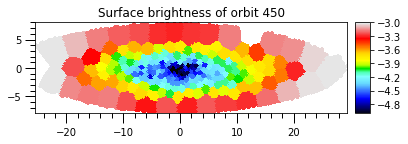

In [21]:
orbit_idx = 450
map_plotter(log_sb_per_orbit[orbit_idx],
            cmap='sauron',
            vmin=-5,
            vmax=-3,
            colorbar=True)
_ = plt.gca().set_title(f'Surface brightness of orbit {orbit_idx}')

Similarly we can get the `v` and `sigma` maps of the orbits, and plot these

In [22]:
orblib0_v = orblib0.losvd_histograms[0].get_mean()
orblib0_sigma = orblib0.losvd_histograms[0].get_sigma()
orblib0_v.shape, orblib0_sigma.shape

/Users/pjethwa/miniconda3/envs/dyn_env_py37/lib/python3.7/site-packages/dynamite-0.0.0-py3.7.egg/dynamite/kinematics.py:527: RuntimeWarning: invalid value encountered in true_divide
  mean /= norm


((720, 235), (720, 235))

/Users/pjethwa/miniconda3/envs/dyn_env_py37/lib/python3.7/site-packages/matplotlib-3.3.4-py3.7-macosx-10.9-x86_64.egg/matplotlib/colors.py:1061: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/Users/pjethwa/miniconda3/envs/dyn_env_py37/lib/python3.7/site-packages/matplotlib-3.3.4-py3.7-macosx-10.9-x86_64.egg/matplotlib/colors.py:576: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


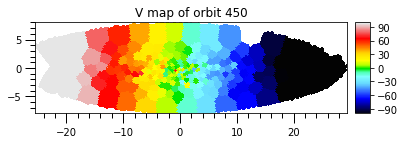

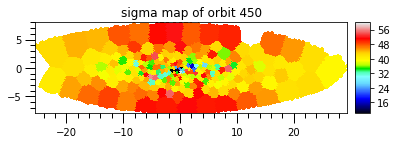

In [23]:
orbit_idx = 450

map_plotter(orblib0_v[orbit_idx],
            cmap='sauron',
            vmin=-100,
            vmax=100,
            colorbar=True)
_ = plt.gca().set_title(f'V map of orbit {orbit_idx}')
plt.show()

map_plotter(orblib0_sigma[orbit_idx],
            cmap='sauron',
            vmin=10.,
            vmax=60,
            colorbar=True)
_ = plt.gca().set_title(f'sigma map of orbit {orbit_idx}')
plt.show()

### Changing the ML

Let's decrease the ML of the parameter set and see how the orbit changes,

In [24]:
from copy import deepcopy 

parset1 = deepcopy(parset0)
parset1['ml'] = 1.
mod1 = dyn.model.Model(system=c.system,
                       settings=c.settings,
                       parspace=c.parspace,
                       parset=parset1)
mod1.setup_directories()
orblib1 = mod1.get_orblib()
orblib1_v = orblib1.losvd_histograms[0].get_mean()
orblib1_sigma = orblib1.losvd_histograms[0].get_sigma()

/Users/pjethwa/miniconda3/envs/dyn_env_py37/lib/python3.7/site-packages/dynamite-0.0.0-py3.7.egg/dynamite/kinematics.py:527: RuntimeWarning: invalid value encountered in true_divide
  mean /= norm


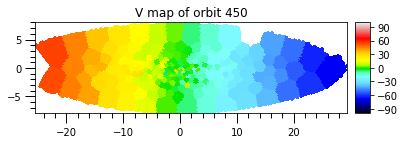

/Users/pjethwa/miniconda3/envs/dyn_env_py37/lib/python3.7/site-packages/matplotlib-3.3.4-py3.7-macosx-10.9-x86_64.egg/matplotlib/colors.py:1061: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/Users/pjethwa/miniconda3/envs/dyn_env_py37/lib/python3.7/site-packages/matplotlib-3.3.4-py3.7-macosx-10.9-x86_64.egg/matplotlib/colors.py:576: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


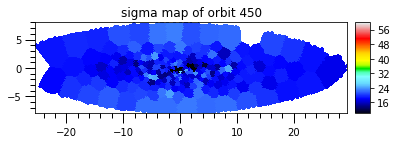

In [25]:
map_plotter(orblib1_v[orbit_idx],
            cmap='sauron',
            vmin=-100,
            vmax=100,
            colorbar=True)
_ = plt.gca().set_title(f'V map of orbit {orbit_idx}')
plt.show()

map_plotter(orblib1_sigma[orbit_idx],
            cmap='sauron',
            vmin=10.,
            vmax=60,
            colorbar=True)
_ = plt.gca().set_title(f'sigma map of orbit {orbit_idx}')
plt.show()

As expected, scaling down the masses by a fator 5 decreseas the amplitude of rotation and the dispersion.

### Rescaling orbit LOSVDs to data velocity bins

To compare model to data, the orbit libraries must be re-binned to the same binning uses for the data. This is handled by the following method,

In [26]:
orblib0_rebinned = BayesLOSVD.rebin_orblib_to_observations(orblib0.losvd_histograms[0])

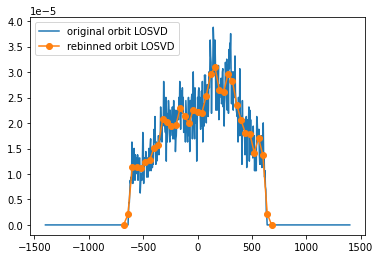

In [27]:
i_orb = 130
i_ap = 10
dx = orblib0.losvd_histograms[0].dx[0]
plt.plot(orblib0.losvd_histograms[0].x,
         orblib0.losvd_histograms[0].y[i_orb,:,i_ap]/dx,
         label='original orbit LOSVD')
dv = BayesLOSVD.data.meta['dv']
plt.plot(BayesLOSVD.data.meta['vcent'],
         orblib0_rebinned[i_orb,:,i_ap]/dv,
         '-o',
         label='rebinned orbit LOSVD')
plt.gca().legend()

As a check, I'll just show that this also works on the other orbit library, which used a different `ml` value

In [28]:
orblib1_rebinned = BayesLOSVD.rebin_orblib_to_observations(orblib1.losvd_histograms[0])

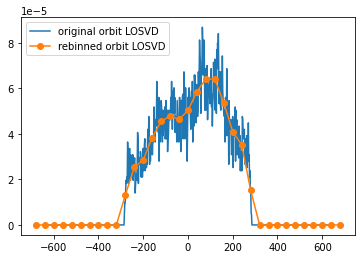

In [29]:
i_orb = 130
i_ap = 10
dx = orblib1.losvd_histograms[0].dx[0]
plt.plot(orblib1.losvd_histograms[0].x,
         orblib1.losvd_histograms[0].y[i_orb,:,i_ap]/dx,
         label='original orbit LOSVD')
dv = BayesLOSVD.data.meta['dv']
plt.plot(BayesLOSVD.data.meta['vcent'],
         orblib1_rebinned[i_orb,:,i_ap]/dv,
         '-o',
         label='rebinned orbit LOSVD')
plt.gca().legend()

# Solving for orbit weights

Solving for orbital weights looks no different from if we were using `GaussHermite` kinematics,

In [30]:
ws0 = mod0.get_weights(orblib0)

[INFO] 09:58:08 - weight_solvers.NNLS - Using WeightSolver : NNLS
[INFO] 09:58:08 - weight_solvers.NNLS - NNLS solution read from existing output


Let's look at the fit. We first extract the best-fit weights, then reconstruct the best-fit model LOSVDs from the orbit LOSVDs and weights,

In [31]:
weights0, chi2_tot0, chi2_kin0 = ws0.solve(orblib0)
model_losvd0 = np.dot(orblib0_rebinned.T, weights0).T

[INFO] 09:58:08 - weight_solvers.NNLS - Using WeightSolver : NNLS
[INFO] 09:58:08 - weight_solvers.NNLS - NNLS solution read from existing output


In order to compare these to the observations, we well have to re-scale the observed LOSVDs by the observed surface density. To do this, we need the MGE,

In [32]:
stars = c.system.get_component_from_name('stars')
mge = stars.mge_lum
projected_masses = mge.get_projected_masses_from_file(mod0.directory_noml)
med_losvd = (projected_masses * BayesLOSVD.data['losvd'].T)
sig_losvd = (projected_masses * BayesLOSVD.data['dlosvd'].T)

Now we can plot the model vs observed LOSVDs, in a selection of apertures,

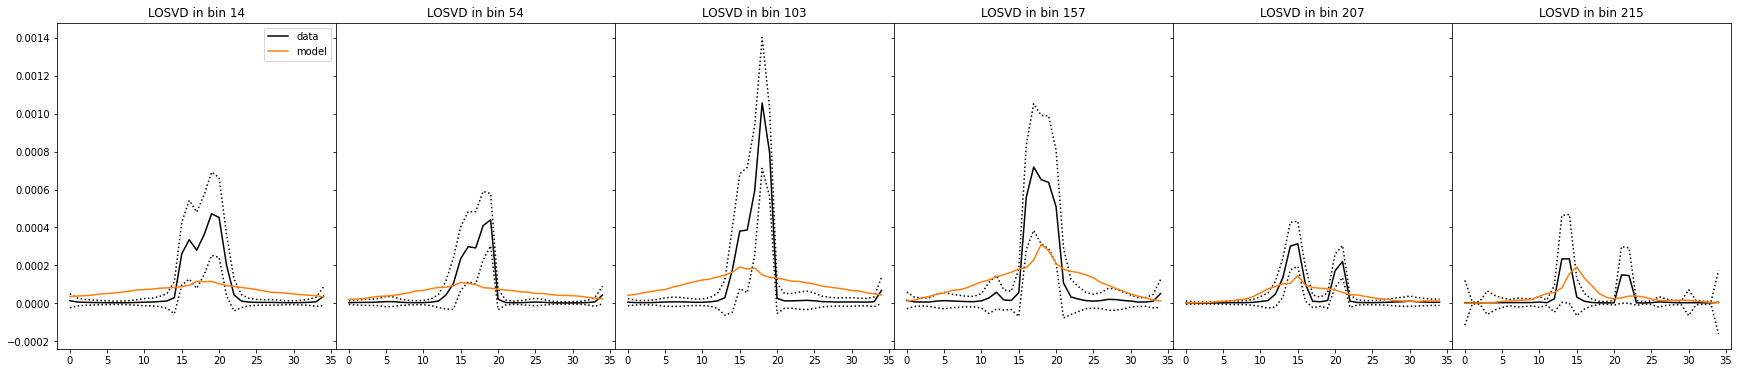

In [33]:
idx_ap_arr = [14, 54, 103, 157, 207, 215]
n_ap = len(idx_ap_arr)
fig, ax = plt.subplots(1, n_ap, figsize=(5*n_ap, n_ap), sharey=True)
for i, idx_ap in enumerate(idx_ap_arr):
    ax[i].plot(med_losvd[:,idx_ap], '-k', label='data')
    ax[i].plot(med_losvd[:,idx_ap]+sig_losvd[:,idx_ap], ':k')
    ax[i].plot(med_losvd[:,idx_ap]-sig_losvd[:,idx_ap], ':k')
    ax[i].plot(model_losvd0[:,idx_ap], '-', color='C1', label='model')
    ax[i].set_title(f'LOSVD in bin {idx_ap}')
ax[0].legend()
fig.subplots_adjust(wspace=0)

We can also plot maps. The following is the observed surface brightness,

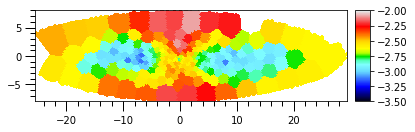

In [34]:
map_plotter(np.log10(projected_masses), cmap='sauron', vmin=-3.5, vmax=-2, colorbar=True)

which we compare to the model surface brightness,

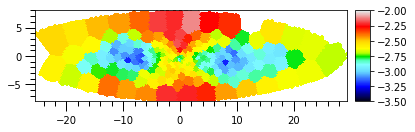

In [35]:
model_sb = np.log10(np.sum(model_losvd0, 0))
map_plotter(model_sb, cmap='sauron', vmin=-3.5, vmax=-2, colorbar=True)

Next is the observed v map

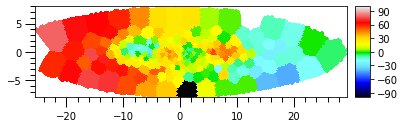

In [36]:
map_plotter(BayesLOSVD.data['v'], cmap='sauron', vmin=-100, vmax=100, colorbar=True)

Which we compare to the model v map,

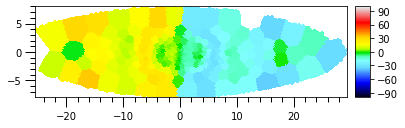

In [37]:
vcnt = np.array(BayesLOSVD.data.meta['vcent'])
dv = BayesLOSVD.data.meta['dv']
vedg = np.concatenate((vcnt-dv/2., [vcnt[-1]+dv/2.]))
hhh0 = dyn.kinematics.Histogram(
    xedg=vedg,
    y=model_losvd0)
vmean0 = hhh0.get_mean()[0]
map_plotter(vmean0, cmap='sauron', vmin=-100, vmax=100, colorbar=True)

Clearly, the surface brightness is well fit, but the velocity map is less well fit. Let's repeat the fit for the rescaled orblit library (with ML=1 compared to 5 for the original),

In [38]:
ws1 = mod1.get_weights(orblib1)
weights, chi2_tot1, chi2_kin1 = ws1.solve(orblib0)
model_losvd1 = np.dot(orblib1_rebinned.T, weights).T

[INFO] 09:58:12 - weight_solvers.NNLS - Using WeightSolver : NNLS
[INFO] 09:58:12 - weight_solvers.NNLS - NNLS solution read from existing output
[INFO] 09:58:12 - weight_solvers.NNLS - Using WeightSolver : NNLS
[INFO] 09:58:12 - weight_solvers.NNLS - NNLS solution read from existing output


/Users/pjethwa/miniconda3/envs/dyn_env_py37/lib/python3.7/site-packages/matplotlib-3.3.4-py3.7-macosx-10.9-x86_64.egg/matplotlib/colors.py:1061: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/Users/pjethwa/miniconda3/envs/dyn_env_py37/lib/python3.7/site-packages/matplotlib-3.3.4-py3.7-macosx-10.9-x86_64.egg/matplotlib/colors.py:576: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


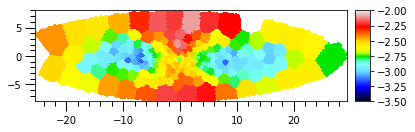

In [39]:
model_sb1 = np.log10(np.sum(model_losvd1, 0))
map_plotter(model_sb1, cmap='sauron', vmin=-3.5, vmax=-2, colorbar=True)

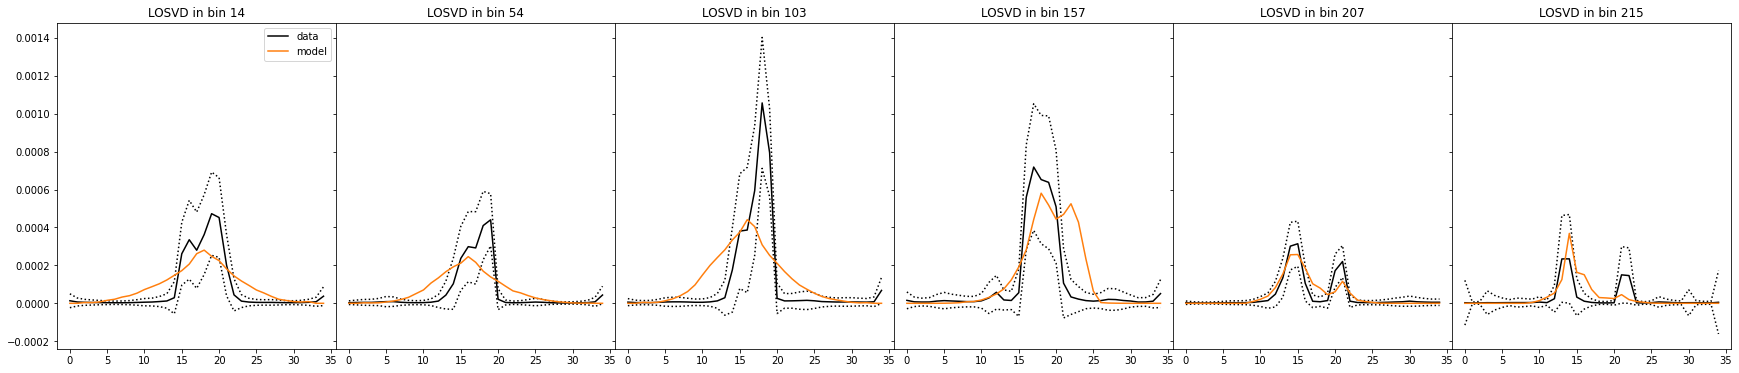

In [40]:
idx_ap_arr = [14, 54, 103, 157, 207, 215]
n_ap = len(idx_ap_arr)
fig, ax = plt.subplots(1, n_ap, figsize=(5*n_ap, n_ap), sharey=True)
for i, idx_ap in enumerate(idx_ap_arr):
    ax[i].plot(med_losvd[:,idx_ap], '-k', label='data')
    ax[i].plot(med_losvd[:,idx_ap]+sig_losvd[:,idx_ap], ':k')
    ax[i].plot(med_losvd[:,idx_ap]-sig_losvd[:,idx_ap], ':k')
    ax[i].plot(model_losvd1[:,idx_ap], '-', color='C1', label='model')
    ax[i].set_title(f'LOSVD in bin {idx_ap}')
ax[0].legend()
fig.subplots_adjust(wspace=0)

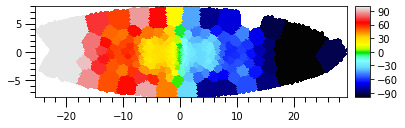

In [41]:
hhh1 = dyn.kinematics.Histogram(
    xedg=vedg,
    y=model_losvd1)
vmean1 = hhh1.get_mean()[0]
map_plotter(vmean1, cmap='sauron', vmin=-100, vmax=100, colorbar=True)

The amplitude of the rotation looks more similar to the data, and this is reflected in the improved chi2,

In [42]:
print('Kin chi2 of model 0:', chi2_kin0)
print('Kin chi2 of model 1:', chi2_kin1)

Kin chi2 of model 0: 67942.50780218602
Kin chi2 of model 1: 36607.361551256545


Neither fit, however, is particularly good. We would need to do a larger parameter search, and use a larger orbit library, to improve this. 